In [1]:
from mnist import MNIST
import numpy as np

In [2]:
mnist_data = MNIST(path='./samples/', gz=True)

In [3]:
train_data = mnist_data.load_training()

In [4]:
len(train_data)

2

In [5]:
len(train_data[0])

60000

In [6]:
len(train_data[1])

60000

In [7]:
len(train_data[0][0])

784

In [8]:
#len(train_data[1][0]) # Since train_data[1] is a list of integers, calling len() on integers causes an error

In [9]:
print(type(train_data[0]), type(train_data[1]))

<class 'list'> <class 'array.array'>


load_training returns a tuple with two lists: first one containing lists of values for data points (60000 lists, each with 784 entries), and second one is a list of labels as integers (60000 integers)

In [10]:
X_train = np.array(train_data[0])
y_train = np.array(train_data[1]).reshape((-1, 1))

In [11]:
X_train.shape

(60000, 784)

In [12]:
y_train.shape

(60000, 1)

In [13]:
X_train.max()

255

In [14]:
X_train.min()

0

In [15]:
y_train.max()

9

In [16]:
y_train.min()

0

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

Let's pick 5 random images from the training set!

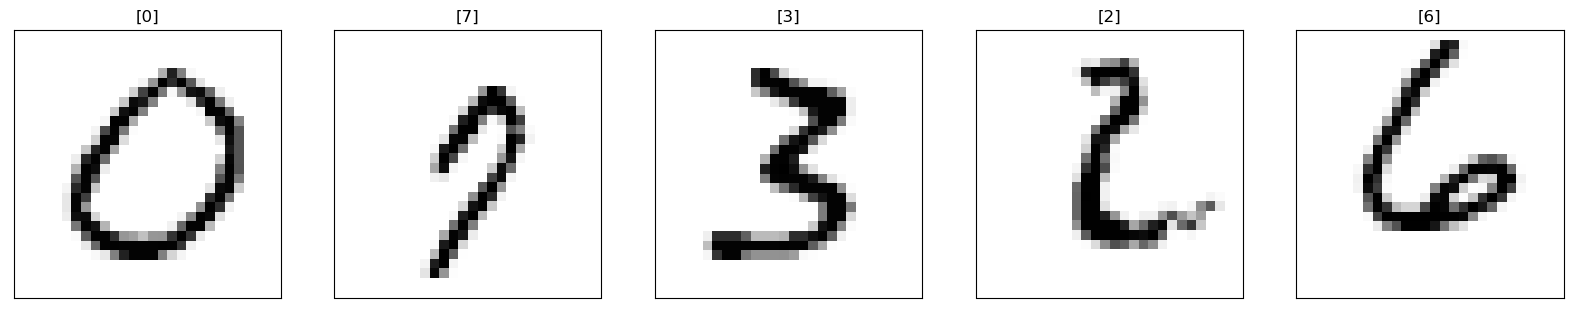

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 20), dpi=100)
for n, ax in zip(np.random.permutation(len(X_train))[:5], axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(y_train[n])
    ax.imshow(X_train[n].reshape(28, 28), cmap="Greys")

In [19]:
X_test, y_test = mnist_data.load_testing()
X_test = np.array(X_test)
y_test = np.array(y_test).reshape(-1, 1)

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [22]:
def normalize(input_tensor, dim=None):
    if dim is None:
        mean = input_tensor.data.mean()
        std = input_tensor.data.std()
    else:
        mean = input_tensor.data.mean(dim=dim)
        std = input_tensor.data.std(dim=dim)

    input_tensor.data = input_tensor.data - mean # mean of 0
    input_tensor.data = input_tensor.data / std.max(torch.tensor(1e-12, dtype=std.dtype, device=std.device)) # standard deviation of 1, prevent division by zero

In [23]:
def convert_and_normalize_input(X, dtype=None, device=None, dim=None):
    X_minmaxed = torch.tensor(X / 255, dtype=dtype, device=device)

    normalize(X_minmaxed, dim=dim)
    X_normalized = X_minmaxed

    return X_normalized

In [25]:
# X_train = convert_and_normalize_input(X_train, dtype=torch.float64, device=device)
# X_test = convert_and_normalize_input(X_test, dtype=torch.float64, device=device)
X_train = torch.tensor(X_train / 255, dtype=torch.float64, device=device)
X_test = torch.tensor(X_test / 255, dtype=torch.float64, device=device)

In [26]:
X_train

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0', dtype=torch.float64)

In [27]:
X_train.shape

torch.Size([60000, 784])

In [28]:
X_test.shape

torch.Size([10000, 784])

In [29]:
def labels_to_onehot(Y, device=None):
    return torch.tensor(Y, dtype=torch.uint8, device=device).eq(torch.arange(0, 10, dtype=torch.uint8, device=device))

In [30]:
Y_train = labels_to_onehot(y_train, device=device)
Y_train.data = Y_train.data.type(torch.float64)
Y_test = labels_to_onehot(y_test, device=device)
Y_test.data = Y_test.data.type(torch.float64)

In [74]:
# Take out some examples from the training set as the validation set (50000 for training, 10000 for validation)
randidx = torch.randperm(len(X_train))
X_val = X_train[randidx[:10000]]
X_train = X_train[randidx[10000:]]
Y_val = Y_train[randidx[:10000]]
Y_train = Y_train[randidx[10000:]]

In [31]:
epsilon = 0.01

w1 = torch.tensor(torch.rand(100, X_train.shape[1], dtype=torch.float64) * 2 * epsilon - epsilon, device=device, requires_grad=True)
b1 = torch.tensor(torch.rand(100, 1, dtype=torch.float64) * 2 * epsilon - epsilon, device=device, requires_grad=True)
w2 = torch.tensor(torch.rand(10, w1.shape[0], dtype=torch.float64) * 2 * epsilon - epsilon, device=device, requires_grad=True)
b2 = torch.tensor(torch.rand(10, 1, dtype=torch.float64) * 2 * epsilon - epsilon, device=device, requires_grad=True)

In [32]:
w1

tensor([[-0.0047,  0.0015,  0.0087,  ..., -0.0029,  0.0072,  0.0030],
        [ 0.0077, -0.0072,  0.0033,  ...,  0.0035,  0.0059, -0.0095],
        [ 0.0021,  0.0032, -0.0014,  ...,  0.0056,  0.0064, -0.0074],
        ...,
        [ 0.0062, -0.0099,  0.0046,  ..., -0.0083,  0.0080, -0.0029],
        [-0.0063, -0.0019,  0.0075,  ...,  0.0069, -0.0071, -0.0097],
        [-0.0070,  0.0022,  0.0023,  ...,  0.0014, -0.0085,  0.0059]],
       device='cuda:0', dtype=torch.float64, requires_grad=True)

In [72]:
def predict(probs, one_hot=False):
    preds = torch.tensor(probs.argmax(dim=1).reshape((-1, 1)), dtype=torch.uint8, device=probs.device)

    if one_hot is True:
        preds.data = preds.eq(torch.arange(0, 10, dtype=torch.uint8, device=probs.device))

    return preds


def accuracy_score(pred, true):
    assert len(pred) == len(true)

    pred = pred.cuda().argmax(dim=1)
    true = true.cuda().argmax(dim=1)

    accuracy = pred.eq(true).sum(dtype=pred.dtype).item() / float(len(true))

    return accuracy


def reset(tensors, e=0.01):
    for tensor in tensors:
        tensor.data = torch.tensor(torch.rand(tensor.size(), dtype=tensor.dtype, device=tensor.device) * 2 * e - e)


def feedforward(input_data, weight_matrices, biase_matrices=None):
    assert biase_matrices is None or len(weight_matrices) == len(biase_matrices)
    
    output = input_data.clone()
    
    for n, weights in enumerate(weight_matrices):
        output = output.mm(weights.t())
        if biase_matrices is not None:
            output = output + biase_matrices[n].t()
        output = torch.sigmoid(output)
    
    return output

def binary_class_cross_entropy_loss(pred, true, per_example=False):
    assert len(pred) == len(true)
    
    loss = torch.sum(-true * torch.log(pred) - (1 - true) * torch.log(1 - pred), dim=1, dtype=pred.dtype)
    if per_example is False:
        loss = loss.sum() / len(true)
        if loss.item() != loss.item(): # if the result is nan (probably due to 0 value inside log functions)
            loss = torch.sum(-true * torch.log(pred + 1e-12) - (1 - true) * torch.log(1 - pred + 1e-12), dtype=pred.dtype)
    
    return loss


def regularization_loss(weight_matrices, regular_coef, n_examples):
    loss = (regular_coef / (2 * n_examples)) * sum([weights.pow(2).sum() for weights in weight_matrices])
    return loss

In [34]:
def loss_function(prob, true, weight_matrices, regular_coef, n_examples):
    return binary_class_cross_entropy_loss(prob, true) + regularization_loss(weight_matrices, regular_coef, n_examples)

In [35]:
# Set up logs
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

In [36]:
# Bundle the weights and biases into two separate lists so that I can use them for my functions
weights = [w1, w2]
biases = [b1, b2]

In [90]:
# Finding the best learning rate
def lr_find(X, Y, weight_matrices, bias_matrices, start_lr=1e-8, reg_coef=0):
    
    weight_matrices = [weight.clone() for weight in weight_matrices]
    bias_matrices = [bias.clone() for bias in bias_matrices]
    params = weight_matrices + bias_matrices
    reset(params)
    
    for param in params:
        param.retain_grad()

    learning_rate = start_lr
    lr_history = []
    loss_history = []
    
    check_interval = 3
    lr_multiplier = 1.2
    
    gradient_exploding = False
    iteration_count = 0
    while not gradient_exploding:
        loss = loss_function(feedforward(X, weight_matrices, bias_matrices), Y, weight_matrices, reg_coef, len(X))
        loss.backward()
        
        for param in params:
            param.data -= learning_rate * param.grad.data
            param.grad.data.zero_()
            
        lr_history.append(learning_rate)
        loss_history.append(loss.item())
        
        iteration_count += 1
        
        if iteration_count > check_interval and iteration_count % check_interval == 0 and loss_history[-1] > loss_history[-1 - check_interval]:
            gradient_exploding = True
        
        else:
            learning_rate *= lr_multiplier
    
    return (lr_history, loss_history)


def lr_plot(lr_list, loss_list):
    plt.xscale('log')
    plt.locator_params(axis='y', nbins=10)
    plt.xlabel('learning rate (in log scale)')
    plt.ylabel('loss')
    plt.grid()
    plt.plot(lr_list, loss_list)

In [86]:
logs = lr_find(X_train, Y_train, weights, biases, start_lr=1e-2, reg_coef=1)

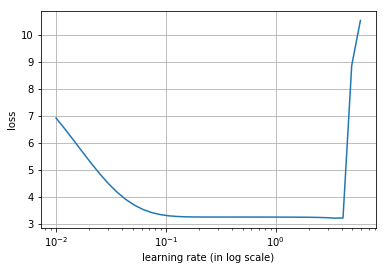

In [91]:
lr_plot(logs[0], logs[1])

In [81]:
logs[1][-20:]

[3.251345560626893,
 3.2497934203785515,
 3.249350771853233,
 3.2491612163554024,
 3.2489798182224634,
 3.248760267532711,
 3.2484880022012828,
 3.24814537304633,
 3.2477055605095693,
 3.247125788010648,
 3.2463345758599167,
 3.2452066273295075,
 3.243510985891766,
 3.2407982344285013,
 3.2361409585890244,
 3.2275105234401487,
 3.210698058995046,
 3.2161527199674493,
 8.723876469253756,
 11.56182543230193]

In [77]:
# Hyperparameters
epoch = 100
lambda_term = 1
learning_rate = 1.0

In [78]:
tol_loss = 1e-3
tol_step = 1e-8

reset_progress = True

if reset_progress is True:
    reset(weights)
    reset(biases)
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

exit_reason = ""

backups = [{'parameters':[param.clone() for param in (weights + biases)],
            'index':len(train_loss_history),
            'train_loss':999 if train_loss_history == [] else train_loss_history[-1]}]

backup_during_training = True
n_checkpoint = 10 # backup the parameters and iteration number n_checkpoint times during a full set of iterations

checkpoint_interval = epoch // n_checkpoint
for iteration in range(epoch):
    output = feedforward(X_train, weights, biases)
    loss = loss_function(output, Y_train, weights, lambda_term, len(X_train))
    
    loss.backward()
    
    for param in (weights + biases):
        param.data -= learning_rate * param.grad.data
        param.grad.data.zero_()

    train_pred = predict(output, one_hot=True)

    train_loss_history.append(loss.item())
    train_acc_history.append(accuracy_score(train_pred, Y_train))
    
    
    val_prob = feedforward(X_val, weights, biases)
    val_pred = predict(val_prob, one_hot=True)

    val_loss_history.append(binary_class_cross_entropy_loss(val_prob, Y_val).item())
    val_acc_history.append(accuracy_score(val_pred, Y_test))
    
    if (iteration + 1) % 10 == 0:
        print(f"\nIteration {iteration + 1}")
        print(f"[Training Loss = {train_loss_history[-1]:.6f}\t"
              f"Training Accuracy = {train_acc_history[-1]:.6f}]\n"
              f"[Validation Loss = {val_loss_history[-1]:.6f}\t\t"
              f"Validation Accuracy = {val_acc_history[-1]:.6f}]")

    if backup_during_training is True and iteration % checkpoint_interval == 0:
        backups.append({'parameters':[param.clone() for param in (weights + biases)],
                        'index':len(train_loss_history),
                        'train_loss':train_loss_history[-1]})


    if train_loss_history[-1] < tol_loss:
        exit_reason = "Loss value less than tol_loss value"
        break
    
    elif len(train_loss_history) > 1 and abs(train_loss_history[-1] - train_loss_history[-2]) < tol_step:
        exit_reason = "Loss value change less than tol_step value"
        break
    
    elif iteration == (epoch - 1):
        exit_reason = "Iteration finished"

test_accuracy = accuracy_score(feedforward(X_test, weights, biases), Y_test)
print(f"\n{exit_reason}")
print(f"Training finished in {iteration + 1} iterations")
print(f"\nFinal training loss = {train_loss_history[-1]}")
print(f"Final training accuracy = {train_acc_history[-1]}")
print(f"\nFinal validation loss = {val_loss_history[-1]}")
print(f"Final validation accuracy = {val_loss_history[-1]}")
print(f"\nTest accuracy = {test_accuracy}")


Iteration 10
[Training Loss = 3.437517	Training Accuracy = 0.112920]
[Validation Loss = 3.430215		Validation Accuracy = 0.113200]

Iteration 20
[Training Loss = 3.350616	Training Accuracy = 0.124940]
[Validation Loss = 3.345103		Validation Accuracy = 0.113100]

Iteration 30
[Training Loss = 3.214999	Training Accuracy = 0.186660]
[Validation Loss = 3.200547		Validation Accuracy = 0.109100]

Iteration 40
[Training Loss = 2.974156	Training Accuracy = 0.287560]
[Validation Loss = 2.952571		Validation Accuracy = 0.101900]

Iteration 50
[Training Loss = 2.611151	Training Accuracy = 0.487820]
[Validation Loss = 2.580184		Validation Accuracy = 0.101400]

Iteration 60
[Training Loss = 2.196824	Training Accuracy = 0.606140]
[Validation Loss = 2.176572		Validation Accuracy = 0.100700]

Iteration 70
[Training Loss = 1.890192	Training Accuracy = 0.690880]
[Validation Loss = 1.882919		Validation Accuracy = 0.097800]

Iteration 80
[Training Loss = 1.673947	Training Accuracy = 0.749920]
[Validation L

In [124]:
list(enumerate([backup['train_loss'] for backup in backups]))

[(0, 0.06908725931491116)]

In [125]:
are_you_sure_you_want_to_revert = False

i = 0

if are_you_sure_you_want_to_revert is True:
    for n, param in enumerate(weights + biases):
        param.data = backups[i]['parameters'][n].data
    train_loss_history = train_loss_history[:backups[i]['index']]
    train_acc_history = train_acc_history[:backups[i]['index']]
    val_loss_history = val_loss_history[:backups[i]['index']]
    val_acc_history = val_acc_history[:backups[i]['index']]

ValueError: x and y must have same first dimension, but have shapes (300,) and (200,)

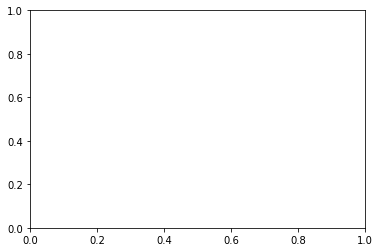

In [42]:
plt.plot(list(range(len(train_loss_history) + 1 - 300, len(train_loss_history) + 1)), train_loss_history[-300:])

In [130]:
len(train_loss_history)

10364

In [43]:
top5_incorrect = binary_class_cross_entropy_loss(feedforward(X_train, weights, biases), Y_train, per_example=True).sort(dim=0, descending=True)[1][:5].cpu().tolist()
top5_incorrect

[24798, 8729, 28357, 59915, 25546]

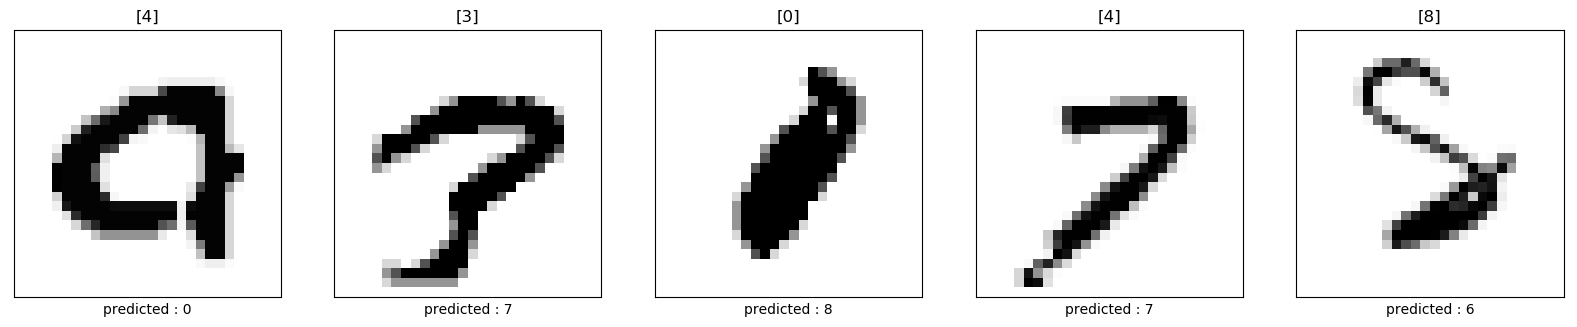

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=len(top5_incorrect), figsize=(20, 20), dpi=100)
for n, ax in zip(top5_incorrect, axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(y_train[n])
    ax.set_xlabel(f"predicted : {predict(feedforward(X_train[n].unsqueeze(0), weights, biases)).item()}")
    ax.imshow(X_train[n].reshape(28, 28), cmap="Greys")

In [142]:
fig.savefig("./most_incorrect_5.png", dpi='figure', orientation='landscape')

In [45]:
top5_correct = binary_class_cross_entropy_loss(feedforward(X_train, weights, biases), Y_train, per_example=True).sort(dim=0, descending=False)[1][:5].cpu().tolist()
top5_correct

[40679, 17248, 32004, 42202, 26969]

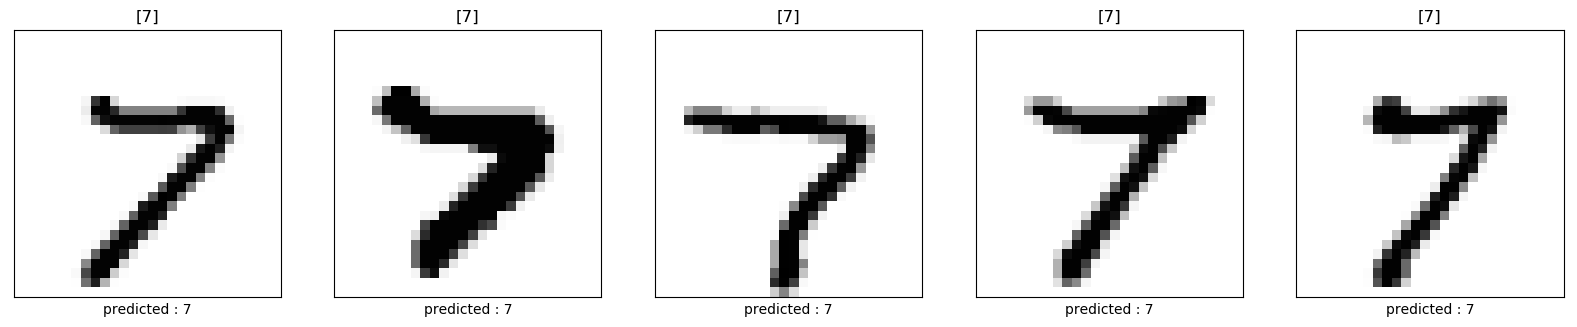

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=len(top5_correct), figsize=(20, 20), dpi=100)
for n, ax in zip(top5_correct, axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(y_train[n])
    ax.set_xlabel(f"predicted : {predict(feedforward(X_train[n].unsqueeze(0), weights, biases)).item()}")
    ax.imshow(X_train[n].reshape(28, 28), cmap="Greys")

In [146]:
fig.savefig("./most_correct_5.png", dpi='figure', orientation='landscape')